## Corriente de electrones en sistemas abiertos de tres puntos cuánticos en configuración lineal

In [1]:
from joblib import delayed, Parallel

from tqdm.auto import tqdm
import numpy as np

import qutip as qt
import matplotlib.pyplot as plt
import scipy
import matplotlib.colors as mcolors

%matplotlib widget

El Hamiltoniano del sistema, en la base $\mathscr{B}=\{\ket{\varnothing}, \ket{L}, \ket{C}, \ket{R}\}$:

$\begin{equation}
    H_{TQD}^{lin}= \begin{pmatrix}
        0 & 0 & 0 & 0 \\ 
        0 & \epsilon_L & -\tau_{12} & 0 \\
        0 & -\tau_{12} & \epsilon_C & -\tau_{23} \\
        0 & 0& -\tau_{23} & \epsilon_R
    \end{pmatrix}
\end{equation}$

In [2]:
# base
E = qt.basis(4, 0)
L = qt.basis(4, 1)
C = qt.basis(4, 2)
R = qt.basis(4, 3)

In [3]:
# parámetros y operadores
tau = 0.3
gammaL = 0.1*tau
gammaR = 0.1*tau
psi0 = E

cL = qt.Qobj(np.array([(0,1,0,0),(0,0,0,0),(0,0,0,0),(0,0,0,0)]))
cR = qt.Qobj(np.array([(0,0,0,1),(0,0,0,0),(0,0,0,0), (0,0,0,0)]))

LL = np.sqrt(gammaL)*cL
LR = np.sqrt(gammaR)*cR

c_ops = [qt.dag(LL),LR]

Establecemos $\epsilon_R=0$, de modo que $\delta_{LR}=\epsilon_L$, $\delta_{RC}=\epsilon_C$. Hacemos $\tau_{LC}=\tau_{CR}=\tau$.

In [4]:
def pixel(deltaLR, deltaRC):
    H = qt.Qobj(np.array([(0,0,0,0),(0,deltaLR,-tau,0), (0,-tau,deltaRC, -tau), (0, 0, -tau, 0)]))
    state = qt.steadystate(H, c_ops)
    pR = (R.overlap(state))
    return pR

In [5]:
# pintamos la corriente normalizada (I=rho_RR) para distintos valores del detuning y de tau
deltaLR = np.linspace(-20, 20, 201) * tau
deltaRC = np.linspace(-20, 20, 201) * tau

pRs = []
deltasLR_mat = []
deltasRC_mat = []

for i in range(len(deltaLR)):
     for j in range(len(deltaRC)):
        deltasRC_mat.append(deltaRC[j])
        deltasLR_mat.append(deltaLR[i])

In [57]:
pbar = tqdm(range(len(deltasLR_mat)), desc='Calculando...')
resultados = Parallel(n_jobs=-1)(delayed(pixel)(deltasLR_mat[i], deltasRC_mat[i]) for i in pbar)
np.save('current_tqd.npy', resultados)

Calculando...:   0%|          | 0/40401 [00:00<?, ?it/s]

In [6]:
from matplotlib.colors import LinearSegmentedColormap


def hex_to_rgba(hex_color):
    """
    Convierte un color en formato hexadecimal a formato RGBA.
    
    Args:
    - hex_color: Color en formato hexadecimal.
    
    Returns:
    - Color en formato RGBA.
    """
    rgb = mcolors.hex2color(hex_color)
    return (*rgb, 1)

def create_custom_cmap(colors, positions):
    """
    Crea un colormap personalizado a partir de una lista de colores y sus posiciones.
    
    Args:
    - colors: Lista de colores en formato hexadecimal.
    - positions: Lista de posiciones normalizadas (entre 0 y 1).
    
    Returns:
    - Colormap personalizado.
    """
    if len(colors) != len(positions):
        raise ValueError("La longitud de 'colors' debe ser igual a la longitud de 'positions'.")
    
    rgba_colors = [hex_to_rgba(color) for color in colors]
    
    cmap_dict = {'red': [], 'green': [], 'blue': []}
    
    for pos, color in zip(positions, rgba_colors):
        for i, channel in enumerate(['red', 'green', 'blue']):
            cmap_dict[channel].append((pos, color[i], color[i]))
    
    return LinearSegmentedColormap('custom_colormap', cmap_dict)

# Definir lista de colores en formato hexadecimal y posiciones
hex_colors = ['w','#C1CFF6','#5F9EA0','#4D8283','#537E83','#DF9595','#E19B9B', '#F17F8A','#F13D70']
positions = [0.0, 0.05, 0.12,0.2,0.28,0.53,0.57,0.72,1]  # Normalizado entre 0 y 1

# Crear el colormap personalizado
custom_cmap = create_custom_cmap(hex_colors, positions)

In [7]:
resultados = np.load('current_tqd.npy')
resultados_mat = np.array(resultados).reshape((len(deltaLR), len(deltaRC)))

Text(0, 0.5, '$I/(e\\Gamma_R)$')

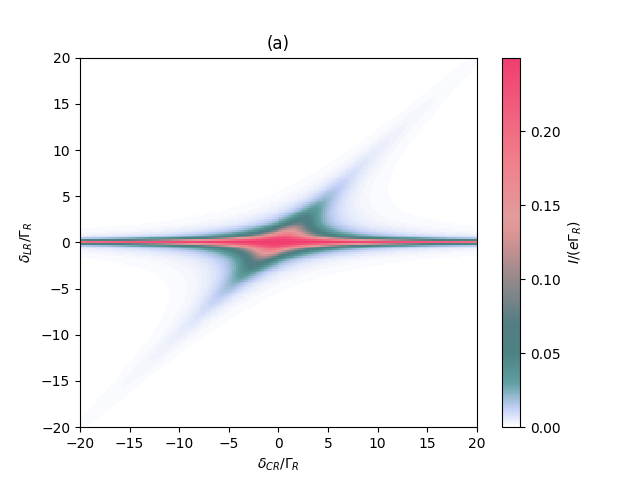

In [8]:
fig, ax = plt.subplots()
im = ax.imshow(resultados_mat, cmap = custom_cmap, origin='lower', aspect='auto',
                interpolation='none', vmin=0, vmax=max(resultados), extent=[min(deltaRC)/tau, max(deltaRC)/tau,
                                                                            min(deltaLR)/tau, max(deltaLR)/tau])
plt.ylabel(r'$\delta_{LR}/\Gamma_R$')
plt.xlabel(r'$\delta_{CR}/\Gamma_R$')
plt.title(r'(a)')
cbar = plt.colorbar(im)
cbar.ax.set_ylabel(r'$I/(e\Gamma_R)$')

# plt.savefig('./figs/current_tqd.svg')

In [9]:
deltaRC_2 = np.linspace(-20, 20, 201) * tau

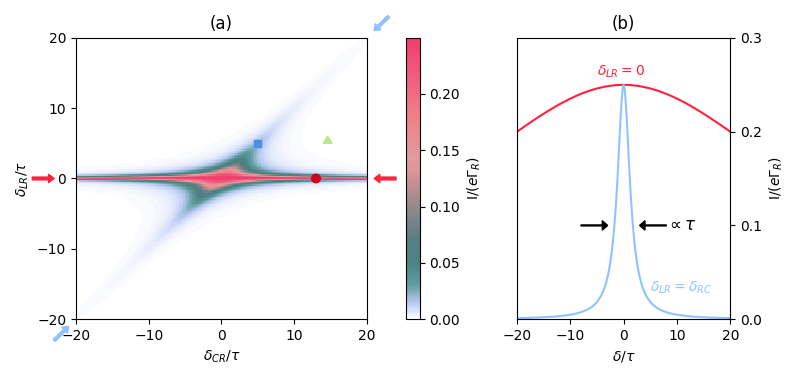

In [10]:
fact=1
fig, axs = plt.subplots(1, 2, figsize=(8*fact, 3.8*fact), gridspec_kw={'width_ratios': [1, 0.55]})
colors = ['#ff213b', '#8fc3ff', '#88e827']

# Figura (a)
im = axs[0].imshow(resultados_mat, cmap = custom_cmap, origin='lower', aspect='auto',
                interpolation='none', vmin=0, vmax=max(resultados), extent=[min(deltaRC)/tau, max(deltaRC)/tau,
                                                                            min(deltaLR)/tau, max(deltaLR)/tau])
axs[0].set_ylabel(r'$\delta_{LR}/\tau$')
axs[0].set_xlabel(r'$\delta_{CR}/\tau$')
axs[0].set_title(r'(a)')
cbar = plt.colorbar(im, pad=0.1)
cbar.ax.set_ylabel(r'I$/(e\Gamma_R)$')

axs[0].set_yticks([-20,-10,0,10,20])

axs[0].annotate("", xy=(-21, -21), xytext=(-23,-23),
            arrowprops=dict(color='#8fc3ff', width=2, headwidth=6, headlength=4), annotation_clip=False)

axs[0].annotate("", xy=(21, 21), xytext=(23,23),
            arrowprops=dict(color='#8fc3ff', width=2, headwidth=6, headlength=4), annotation_clip=False)

axs[0].annotate("", xy=(-23, 0), xytext=(-26, 0),
            arrowprops=dict(color='#ff213b', width=2, headwidth=6, headlength=4), annotation_clip=False)
axs[0].annotate("", xy=(21, 0), xytext=(24, 0),
            arrowprops=dict(color='#ff213b', width=2, headwidth=6, headlength=4), annotation_clip=False)

# Figura (b)

axs[1].set_xlabel(r'$\delta/\tau$')
axs[1].set_ylabel(r'I$/(e\Gamma_R)$', labelpad=None)
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")
axs[1].set_title(r'(b)')

axs[1].set_yticks([0, 0.1, 0.2, 0.3])

axs[1].set_xlim(min(deltaRC) /tau, max(deltaRC) / tau)
axs[1].set_ylim(0, 0.3)

x_0 = 8
dx = 4
axs[1].arrow(-x_0, 0.1, dx, 0, color='k', head_width=0.01, head_length=1)
axs[1].arrow(x_0, 0.1, -dx, 0, color='k', head_width=0.01, head_length=1)
axs[1].text(8, 0.1, r'$\propto\tau$',fontsize = 12, va='center')
axs[1].set_title('(b)')

plt.subplots_adjust(wspace=0.2)
plt.tight_layout()


deltaLR_2=0
pRs=[]
for d in deltaRC_2:
    H = qt.Qobj(np.array([(0,0,0,0),(0,deltaLR_2,-tau,0), (0,-tau,d, -tau), (0, 0, -tau, 0)]))
    state = qt.steadystate(H, c_ops)
    pRs.append((R.overlap(state)))

plt.plot(deltaRC_2/tau, pRs, color = '#ff213b')
plt.text(-5, 0.26, r'$\delta_{LR}=0$',fontsize = 10,color = '#ff213b')


pRs=[]
for d in deltaRC_2:
    H = qt.Qobj(np.array([(0,0,0,0),(0,d,-tau,0), (0,-tau,d, -tau), (0, 0, -tau, 0)]))
    state = qt.steadystate(H, c_ops)
    pRs.append((R.overlap(state)))

plt.plot(deltaRC_2/tau, pRs, color = '#8fc3ff')
plt.text(5, 0.03, r'$\delta_{LR}=\delta_{RC}$',fontsize = 10,color = '#8fc3ff')

from matplotlib.patches import PathPatch
from matplotlib.path import Path
from matplotlib.patches import Circle


codes1 = [Path.MOVETO] + [Path.LINETO]*3 + [Path.CLOSEPOLY]
vertices1 = [(4.5, 4.5), (4.5, 5.5), (5.5, 5.5), (5.5, 4.5), (0, 0)]

codes2 = [Path.MOVETO] + [Path.LINETO]*2 + [Path.CLOSEPOLY]
vertices2 = [(14, 5), (14.6, 6), (15.2, 5), (0, 0)]

path1 = Path(vertices1, codes1)
path2 = Path(vertices2, codes2)

pathpatch1 = PathPatch(path1, facecolor='#4A90E2', edgecolor='#4A90E2')
pathpatch2 = PathPatch(path2, facecolor='#B8E986', edgecolor='#B8E986')
patch3= Circle((13,0), radius=0.6, color='#D0021B')

axs[0].add_patch(pathpatch1)
axs[0].add_patch(pathpatch2)
axs[0].add_patch(patch3)

plt.savefig('./figs/current_tqd.pdf')